In [1]:
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
from scipy.stats import pearsonr, spearmanr
import scipy
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import statsmodels.api as sm
import wrangle

In [2]:
df = wrangle.get_zillow_data()

In [3]:
df.shape

(52442, 63)

In [4]:
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52442 non-null  float64
 1   parcelid                      52442 non-null  int64  
 2   id                            52442 non-null  int64  
 3   airconditioningtypeid         13638 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   basementsqft                  47 non-null     float64
 6   bathroomcnt                   52442 non-null  float64
 7   bedroomcnt                    52442 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         33741 non-null  float64
 10  calculatedbathnbr             52305 non-null  float64
 11  decktypeid                    389 non-null    float64
 12  finishedfloor1squarefeet      4381 non-null   float64
 13  c

In [6]:
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [7]:
# turning numerical data to designated county
df['fips'] = df['fips'].replace(6037.0, 'Los Angeles,CA')
df['fips'] = df['fips'].replace(6059.0, 'Orange,CA')
df['fips'] = df['fips'].replace(6111.0, 'Ventura,CA')

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

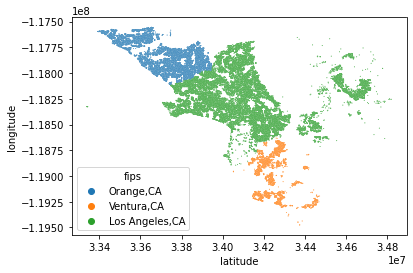

In [8]:
sns.scatterplot(df.latitude, df.longitude, s=1, hue=df.fips)